# Segmenting and Clustering Neigbhourhoods in Toronto

## Initial Setup

In [1]:
# Install folium & beautifulsoup
!pip install folium
!pip install beautifulsoup4
!pip install seaborn==0.9.0

You should consider upgrading via the 'c:\users\tan.c.8\appdata\local\continuum\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\tan.c.8\appdata\local\continuum\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\tan.c.8\appdata\local\continuum\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import json
from bs4 import BeautifulSoup
from html.parser import HTMLParser

import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline

## Retrieving and Pre-processing Toronto Neighbourhood Data

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

resp = requests.get(url)
toronto_html = BeautifulSoup(resp.content)

C:\Users\tan.c.8\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\tan.c.8\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [4]:
soup = BeautifulSoup(str(toronto_html))

C:\Users\tan.c.8\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\tan.c.8\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [5]:
neighborhood_table = soup.find('table')

In [6]:
table_str = str(neighborhood_table.extract())

In [7]:
toronto_df = pd.read_html(table_str)[0]

In [8]:
toronto_df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [9]:
toronto_df.columns = ['PostalCode'] + list(toronto_df.columns)[1:]
toronto_df.head()

,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [10]:
toronto_df.shape

(180, 3)

In [11]:
toronto_df.Borough.value_counts()

Not assigned        77
North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
East Toronto         5
East York            5
York                 5
Mississauga          1
Name: Borough, dtype: int64

In [12]:
# Remove cells that have boroughs that are not assigned
borough_na = toronto_df[toronto_df.Borough == 'Not assigned']
toronto_df.drop(borough_na.index, inplace=True)

In [13]:
toronto_df.head()

,PostalCode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [14]:
toronto_df.shape

(103, 3)

In [15]:
# Combine neigbhourhoods with the same postal codes into a single row

toronto_df = toronto_df.groupby(['PostalCode', 'Borough'])['Neighbourhood'].apply(lambda x:', '.join(x)).to_frame()

In [16]:
toronto_df.reset_index(inplace=True)
toronto_df.head()

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [17]:
# Further check for "Not assigned" Neighbourhoods
toronto_df[toronto_df.Neighbourhood == "Not assigned"]

,PostalCode,Borough,Neighbourhood


## Retrieve and merge lat, long to dataframe

In [18]:
geo_url = "https://cocl.us/Geospatial_data"

geocode_df = pd.read_csv(geo_url)
geocode_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geocode_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [19]:
toronto_df = pd.merge(toronto_df, geocode_df, on='PostalCode')
toronto_df.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Visualizing Toronto Dataset

In [20]:
toronto_latlong = [43.653225, -79.383186]

In [21]:
# create map of Toronto using latitude and longitude values
toronto_map = folium.Map(location=toronto_latlong, zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#2E7D32',
        fill=True,
        fill_color='#FFEB3B',
        fill_opacity=0.75,
        parse_html=False).add_to(toronto_map)

toronto_map

## Foursquare API

In [22]:
search_url = 'https://api.foursquare.com/v2/venues/search'

In [71]:
CLIENT_ID = 'Your ID' # your Foursquare ID
CLIENT_SECRET = 'Your Client Secret' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: Your ID
CLIENT_SECRET:Your Client Secret


In [24]:
toronto_df.loc[0, 'Borough']

'Scarborough'

In [25]:
print('Latitude and longitude values of {} are {}, {}.'.format(toronto_df.loc[0, 'Borough'], 
                                                               toronto_df.loc[0, 'Latitude'], 
                                                               toronto_df.loc[0, 'Longitude']))

Latitude and longitude values of Scarborough are 43.806686299999996, -79.19435340000001.


In [26]:
params = dict(
  client_id=CLIENT_ID,
  client_secret=CLIENT_SECRET,
  v=VERSION,
  ll=f"{toronto_df.loc[0, 'Latitude']}, {toronto_df.loc[0, 'Longitude']}",
  radius=500,
  limit=100
)

In [27]:
resp = requests.get(url=search_url, params=params)
data = resp.json()

In [28]:
data['response']['venues'][0]

{'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/hikingtrail_',
    'suffix': '.png'},
   'id': '4bf58dd8d48988d159941735',
   'name': 'Trail',
   'pluralName': 'Trails',
   'primary': True,
   'shortName': 'Trail'}],
 'hasPerk': False,
 'id': '4e389459b61c438b547e8ed4',
 'location': {'cc': 'CA',
  'country': 'Canada',
  'distance': 732,
  'formattedAddress': ['Canada'],
  'labeledLatLngs': [{'label': 'display',
    'lat': 43.80178186082014,
    'lng': -79.20042735921538}],
  'lat': 43.80178186082014,
  'lng': -79.20042735921538},
 'name': 'Rouge Park - Woodland Trail',
 'referralId': 'v-1597975509'}

In [29]:
search_url = 'https://api.foursquare.com/v2/venues/search'
def get_venues(neighbourhood, lat, long, limit=100, radius=250):
    params = dict(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        v=VERSION,
        ll=f"{lat}, {long}",
        radius=radius,
        limit=limit
    )
    venues = []
    data = requests.get(url=search_url, params=params).json()
    for v in data['response']['venues']:
        venues.append([neighbourhood, lat, long, v['name'], v['location']['lat'], v['location']['lng'], 
                       ', '.join(x['name'] for x in v['categories'])])
    return venues

In [30]:
nbr_venues_df = pd.DataFrame()
columns=['Neighbourhood', 'NeighbourhoodLat', 'NeighbourhoodLong', 'VenueName', 'VenueLat', 'VenueLong', 'VenueCategory']

In [31]:
for name, lat, long in zip(toronto_df.Neighbourhood, toronto_df.Latitude, toronto_df.Longitude):
    nbr_venues_df = nbr_venues_df.append(get_venues(name, lat, long))

In [32]:
nbr_venues_df.columns = columns

In [33]:
nbr_venues_df.head()

,Neighbourhood,NeighbourhoodLat,NeighbourhoodLong,VenueName,VenueLat,VenueLong,VenueCategory
0,"Malvern, Rouge",43.806686,-79.194353,Rouge Park - Woodland Trail,43.801782,-79.200427,Trail
1,"Malvern, Rouge",43.806686,-79.194353,Shell,43.803227,-79.192414,Gas Station
2,"Malvern, Rouge",43.806686,-79.194353,Alvin Curling Public School,43.808683,-79.190103,Elementary School
3,"Malvern, Rouge",43.806686,-79.194353,Kaycan - SCARBOROUGH,43.806768,-79.197875,Building
4,"Malvern, Rouge",43.806686,-79.194353,Tim Hortons,43.802000,-79.198169,Coffee Shop


In [34]:
nbr_venues_df.shape

(9865, 7)

In [35]:
nbr_venues_df.to_csv('toronto_boroughs_and_venues.csv')

## Analyze Venue Data

In [36]:
nbr_venues_df = pd.read_csv('toronto_boroughs_and_venues.csv')
nbr_venues_df.drop(['Unnamed: 0'], axis=1, inplace=True)
nbr_venues_df.head()

,Neighbourhood,NeighbourhoodLat,NeighbourhoodLong,VenueName,VenueLat,VenueLong,VenueCategory
0,"Malvern, Rouge",43.806686,-79.194353,Rouge Park - Woodland Trail,43.801782,-79.200427,Trail
1,"Malvern, Rouge",43.806686,-79.194353,Shell,43.803227,-79.192414,Gas Station
2,"Malvern, Rouge",43.806686,-79.194353,Alvin Curling Public School,43.808683,-79.190103,Elementary School
3,"Malvern, Rouge",43.806686,-79.194353,Kaycan - SCARBOROUGH,43.806768,-79.197875,Building
4,"Malvern, Rouge",43.806686,-79.194353,Tim Hortons,43.802000,-79.198169,Coffee Shop


In [37]:
nbr_venues_df.VenueCategory.replace('', np.nan, inplace=True)
nbr_venues_df.dropna(inplace=True)
nbr_venues_df.shape

(8774, 7)

In [38]:
nbr_venues_df.VenueCategory.value_counts()

Office                                      469
Residential Building (Apartment / Condo)    394
Building                                    252
Park                                        184
Salon / Barbershop                          183
Coffee Shop                                 176
Automotive Shop                             166
Church                                      160
Medical Center                              144
Doctor's Office                             135
Pizza Place                                 129
Bank                                        124
Dentist's Office                            114
Café                                        111
Convenience Store                           106
Restaurant                                   91
School                                       90
Bus Line                                     86
Gas Station                                  84
Furniture / Home Store                       78
Bakery                                  

In [39]:
# Drop categories that have < 15 counts
common_categories = nbr_venues_df.VenueCategory.unique()[nbr_venues_df.VenueCategory.value_counts()>15]

In [40]:
nbr_venues_df = nbr_venues_df[nbr_venues_df.VenueCategory.isin(common_categories)]
nbr_venues_df.shape

(6305, 7)

In [41]:
from IPython.core.display import HTML

display(HTML(nbr_venues_df.groupby('Neighbourhood').count().to_html()))

,NeighbourhoodLat,NeighbourhoodLong,VenueName,VenueLat,VenueLong,VenueCategory
Neighbourhood,,,,,,
Agincourt,74,74,74,74,74,74
"Alderwood, Long Branch",66,66,66,66,66,66
"Bathurst Manor, Wilson Heights, Downsview North",69,69,69,69,69,69
Bayview Village,70,70,70,70,70,70
"Bedford Park, Lawrence Manor East",62,62,62,62,62,62
Berczy Park,54,54,54,54,54,54
"Birch Cliff, Cliffside West",61,61,61,61,61,61
"Brockton, Parkdale Village, Exhibition Place",77,77,77,77,77,77
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",46,46,46,46,46,46


In [42]:
nbr_venues_df.groupby('Neighbourhood').count().VenueCategory.min()

13

In [43]:
# add neighborhood column back to dataframe
category_onehot = pd.get_dummies(nbr_venues_df.VenueCategory)
category_onehot['Neighbourhood'] = nbr_venues_df.Neighbourhood

# move neighborhood column to the first column
fixed_columns = [category_onehot.columns[-1]] + list(category_onehot.columns[:-1])
category_onehot = category_onehot[fixed_columns]

In [44]:
category_onehot.head()

,Neighbourhood,African Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,...,Tattoo Parlor,Tech Startup,Temple,Thai Restaurant,Theme Park,Thrift / Vintage Store,Trail,Veterinarian,Winery,Zoo Exhibit
0,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
category_onehot.shape

(6305, 132)

In [46]:
category_onehot = category_onehot.groupby('Neighbourhood').mean().reset_index()
category_onehot

,Neighbourhood,African Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,...,Tattoo Parlor,Tech Startup,Temple,Thai Restaurant,Theme Park,Thrift / Vintage Store,Trail,Veterinarian,Winery,Zoo Exhibit
0,Agincourt,0.000000,0.000000,0.000000,0.000000,0.000000,0.013514,0.000000,0.027027,0.148649,...,0.000000,0.027027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Alderwood, Long Branch",0.000000,0.000000,0.015152,0.030303,0.000000,0.000000,0.015152,0.000000,0.000000,...,0.000000,0.015152,0.000000,0.015152,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014493,0.000000,0.000000
3,Bayview Village,0.000000,0.000000,0.000000,0.028571,0.014286,0.000000,0.000000,0.000000,0.014286,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,"Bedford Park, Lawrence Manor East",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.016129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Berczy Park,0.000000,0.018519,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.018519,...,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,"Birch Cliff, Cliffside West",0.000000,0.016393,0.000000,0.016393,0.000000,0.016393,0.016393,0.016393,0.016393,...,0.000000,0.016393,0.000000,0.016393,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.012987,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,"Business reply mail Processing Centre, South C...",0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.021739,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021739
9,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Top Venues

In [47]:
num_top_venues = 5

for nbrhood in category_onehot['Neighbourhood']:
    print("---- "+nbrhood+" ----")
    temp = category_onehot[category_onehot['Neighbourhood'] == nbrhood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                venue  freq
0     Automotive Shop  0.15
1            Building  0.11
2              Office  0.09
3              Church  0.05
4  Chinese Restaurant  0.04


---- Alderwood, Long Branch ----
                venue  freq
0              Office  0.14
1    Dentist's Office  0.05
2                Bank  0.05
3      Medical Center  0.05
4  Salon / Barbershop  0.05


---- Bathurst Manor, Wilson Heights, Downsview North ----
                                      venue  freq
0  Residential Building (Apartment / Condo)  0.13
1                           Doctor's Office  0.10
2                            Medical Center  0.07
3                                      Bank  0.06
4                                    Office  0.06


---- Bayview Village ----
                                      venue  freq
0  Residential Building (Apartment / Condo)  0.10
1                                    Church  0.09
2                           Doctor's Office  0.07
3                    

                 venue  freq
0               Church  0.17
1               Office  0.08
2  Government Building  0.08
3             Building  0.08
4                 Bank  0.04


---- Hillcrest Village ----
                                      venue  freq
0  Residential Building (Apartment / Condo)  0.06
1                                    School  0.06
2                            Medical Center  0.06
3                       Housing Development  0.04
4                               Pizza Place  0.04


---- Humber Summit ----
                    venue  freq
0         Automotive Shop  0.16
1             Gas Station  0.07
2                  Church  0.06
3      Italian Restaurant  0.04
4  Furniture / Home Store  0.04


---- Humberlea, Emery ----
                                      venue  freq
0                                  Building  0.10
1                    Furniture / Home Store  0.08
2                                   Factory  0.08
3                            Hardware Store  0.06

                   venue  freq
0        Automotive Shop  0.09
1                 Office  0.06
2         Medical Center  0.04
3     Miscellaneous Shop  0.03
4  General Entertainment  0.03


---- Runnymede, Swansea ----
                venue  freq
0      Medical Center  0.10
1    Dentist's Office  0.10
2  Salon / Barbershop  0.07
3              Office  0.05
4         Pizza Place  0.05


---- Runnymede, The Junction North ----
                venue  freq
0     Automotive Shop  0.13
1  Salon / Barbershop  0.04
2         Gas Station  0.04
3         Event Space  0.04
4                Park  0.04


---- Scarborough Village ----
                                      venue  freq
0  Residential Building (Apartment / Condo)  0.10
1                           Automotive Shop  0.08
2                                  Building  0.06
3                               Gas Station  0.05
4                               Pizza Place  0.05


---- South Steeles, Silverstone, Humbergate, Jamestown, Mount Olive, Be

4                                      Pool  0.06




## Create Pandas Dataframe

In [48]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [49]:
indicators = ['st', 'nd', 'rd']
num_top_venues = 10

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
nbr_venues_sorted_df = pd.DataFrame(columns=columns)
nbr_venues_sorted_df['Neighbourhood'] = category_onehot['Neighbourhood']

for ind in np.arange(category_onehot.shape[0]):
    nbr_venues_sorted_df.iloc[ind, 1:] = return_most_common_venues(category_onehot.iloc[ind, :], num_top_venues)

nbr_venues_sorted_df.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Automotive Shop,Building,Office,Church,Coffee Shop,Chinese Restaurant,Doctor's Office,Storage Facility,Tech Startup,Event Space
1,"Alderwood, Long Branch",Office,Dentist's Office,Salon / Barbershop,Bank,Gas Station,Medical Center,Asian Restaurant,BBQ Joint,Café,Pizza Place
2,"Bathurst Manor, Wilson Heights, Downsview North",Residential Building (Apartment / Condo),Doctor's Office,Medical Center,Office,Bank,Salon / Barbershop,Spa,Building,Bar,Coffee Shop
3,Bayview Village,Residential Building (Apartment / Condo),Church,Doctor's Office,Salon / Barbershop,Office,Asian Restaurant,Medical Center,School,Gas Station,Japanese Restaurant
4,"Bedford Park, Lawrence Manor East",Salon / Barbershop,Italian Restaurant,Spa,Restaurant,Hobby Shop,Café,Sandwich Place,Dentist's Office,Coffee Shop,Juice Bar


## Clustering Neighbourhoods

In [50]:
from sklearn.cluster import KMeans

In [51]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)

In [52]:
X = category_onehot.drop(['Neighbourhood'], axis=1)
X.head()

,African Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,...,Tattoo Parlor,Tech Startup,Temple,Thai Restaurant,Theme Park,Thrift / Vintage Store,Trail,Veterinarian,Winery,Zoo Exhibit
0,0.0,0.0,0.000000,0.000000,0.000000,0.013514,0.000000,0.027027,0.148649,0.013514,...,0.0,0.027027,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.015152,0.030303,0.000000,0.000000,0.015152,0.000000,0.000000,0.030303,...,0.0,0.015152,0.0,0.015152,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.014493,0.0,0.0
3,0.0,0.0,0.000000,0.028571,0.014286,0.000000,0.000000,0.000000,0.014286,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.016129,0.0,0.0,0.0,0.000000,0.0,0.0


In [53]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 2, 0, 1, 0, 0])

In [54]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [55]:
scores = [get_inertia(x) for x in range(2, 21)]

Text(0,0.5,'Error')

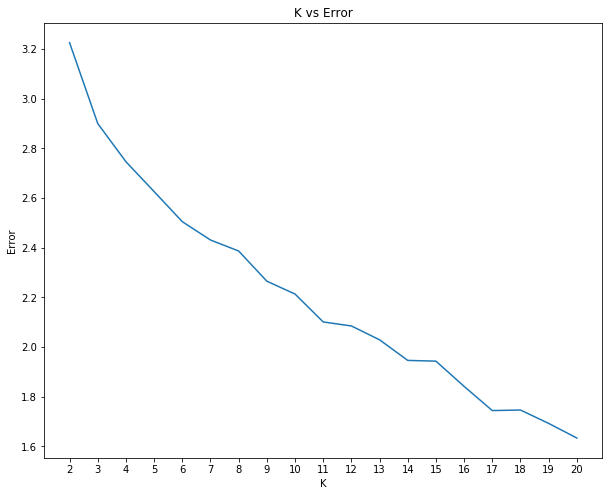

In [56]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores)
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

In [57]:
# train model with k=8
kmeans = KMeans(n_clusters=8)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [58]:
kmeans.labels_[:8]

array([7, 4, 2, 3, 4, 5, 3, 1])

## Create new dataframe with cluster

In [59]:
# add cluster labels
nbr_venues_sorted_df.insert(0, 'Cluster Labels', kmeans.labels_)

In [60]:
toronto_nbr_df = toronto_df
toronto_nbr_df = toronto_nbr_df.join(nbr_venues_sorted_df.set_index('Neighbourhood'), on='Neighbourhood')
toronto_nbr_df.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,0,Office,Automotive Shop,Factory,Doctor's Office,Building,Restaurant,Salon / Barbershop,Dentist's Office,Coffee Shop,Medical Center
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,7,Automotive Shop,Office,Medical Center,Park,Nail Salon,General Entertainment,Miscellaneous Shop,Salon / Barbershop,Italian Restaurant,Church
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,3,Residential Building (Apartment / Condo),Electronics Store,Church,Restaurant,Thrift / Vintage Store,Bank,Salon / Barbershop,Bus Line,Building,School
3,M1G,Scarborough,Woburn,43.770992,-79.216917,3,Cosmetics Shop,Pizza Place,Residential Building (Apartment / Condo),Church,Building,Indian Restaurant,Coffee Shop,Pharmacy,Salon / Barbershop,Convenience Store
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,4,Medical Center,Building,Bakery,Residential Building (Apartment / Condo),Doctor's Office,Office,Automotive Shop,Caribbean Restaurant,Pool,Skating Rink


In [61]:
# create map
map_clusters = folium.Map(location=toronto_latlong, zoom_start=11)

# set color scheme for the clusters
x = np.arange(14)
ys = [i + x + (i*x)**2 for i in range(9)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_nbr_df['Latitude'], toronto_nbr_df['Longitude'], toronto_nbr_df['Neighbourhood'], toronto_nbr_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

## Deeper Look into Each Clusters

### Cluster 0

In [62]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 0, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Malvern, Rouge",0,Office,Automotive Shop,Factory,Doctor's Office,Building,Restaurant,Salon / Barbershop,Dentist's Office,Coffee Shop,Medical Center
16,Upper Rouge,0,Zoo Exhibit,Park,Office,Cosmetics Shop,Pizza Place,Playground,Auto Dealership,Bakery,Art Gallery,Pharmacy
29,"Northwood Park, York University",0,Office,Building,Furniture / Home Store,Automotive Shop,Salon / Barbershop,Bank,Doctor's Office,Lounge,Pizza Place,Pharmacy
41,"The Danforth West, Riverdale",0,Greek Restaurant,Spa,Salon / Barbershop,Office,Gym / Fitness Center,Cosmetics Shop,Restaurant,Miscellaneous Shop,Park,Coffee Shop
48,"Moore Park, Summerhill East",0,Building,Office,Residential Building (Apartment / Condo),Park,Bank,Trail,Gym / Fitness Center,Martial Arts School,Playground,Restaurant
85,"Queen's Park, Ontario Provincial Government",0,Government Building,Medical Center,Building,Restaurant,Office,Doctor's Office,Lounge,Event Space,Sandwich Place,Coffee Shop
87,"Business reply mail Processing Centre, South C...",0,Building,Office,Rental Car Location,Convenience Store,Gym / Fitness Center,Medical Center,Athletics & Sports,Government Building,Fast Food Restaurant,Restaurant
92,"Mimico NW, The Queensway West, South of Bloor,...",0,Office,Coworking Space,Automotive Shop,Miscellaneous Shop,Fast Food Restaurant,Building,Coffee Shop,Furniture / Home Store,Hardware Store,Factory
97,"Humberlea, Emery",0,Building,Furniture / Home Store,Factory,Hardware Store,Church,Residential Building (Apartment / Condo),Automotive Shop,Bank,Office,Storage Facility
102,"Northwest, West Humber - Clairville",0,Building,Office,Factory,Automotive Shop,Hotel,Café,Auto Dealership,Event Space,Rental Car Location,Professional & Other Places


### Cluster 1

In [63]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 1, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,York Mills West,1,Residential Building (Apartment / Condo),Office,Park,Building,Medical Center,Church,Government Building,Rental Car Location,Laundry Service,Bus Line
45,Davisville North,1,Residential Building (Apartment / Condo),Office,Hotel,Park,Medical Center,Building,Scenic Lookout,Convenience Store,Department Store,Restaurant
49,"Summerhill West, Rathnelly, South Hill, Forest...",1,Residential Building (Apartment / Condo),Office,Building,Doctor's Office,Dentist's Office,Medical Center,Athletics & Sports,Café,Spiritual Center,Government Building
50,Rosedale,1,Residential Building (Apartment / Condo),Office,Park,Building,Salon / Barbershop,Trail,Government Building,Bank,Pet Store,Mexican Restaurant
52,Church and Wellesley,1,Residential Building (Apartment / Condo),Spa,Building,Office,Doctor's Office,Hotel,Bank,Smoke Shop,Gym / Fitness Center,General Entertainment
65,"The Annex, North Midtown, Yorkville",1,Residential Building (Apartment / Condo),Office,Building,Sandwich Place,General Entertainment,Café,Japanese Restaurant,Hotel,Medical Center,Pet Service
78,"Brockton, Parkdale Village, Exhibition Place",1,Office,Residential Building (Apartment / Condo),Tech Startup,Building,Café,Coffee Shop,Bar,Convenience Store,Pizza Place,Medical Center
91,"Old Mill South, King's Mill Park, Sunnylea, Hu...",1,Residential Building (Apartment / Condo),Office,Bus Line,Convenience Store,Elementary School,Park,Playground,High School,Grocery Store,School


### Cluster 2

In [64]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 2, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,"Willowdale, Willowdale East",2,Residential Building (Apartment / Condo),Bank,Office,Park,Coffee Shop,Restaurant,Salon / Barbershop,Building,Electronics Store,Japanese Restaurant
24,"Willowdale, Willowdale West",2,Residential Building (Apartment / Condo),Medical Center,Park,Bank,Financial or Legal Service,Dentist's Office,Doctor's Office,Pizza Place,Event Space,Salon / Barbershop
28,"Bathurst Manor, Wilson Heights, Downsview North",2,Residential Building (Apartment / Condo),Doctor's Office,Medical Center,Office,Bank,Salon / Barbershop,Spa,Building,Bar,Coffee Shop
34,Victoria Village,2,Residential Building (Apartment / Condo),Automotive Shop,Office,Bank,Miscellaneous Shop,Park,Bus Stop,Building,Playground,Storage Facility
59,"Harbourfront East, Union Station, Toronto Islands",2,Residential Building (Apartment / Condo),Office,Building,Coffee Shop,Doctor's Office,Fried Chicken Joint,Indian Restaurant,Rental Car Location,Medical Center,Plaza
99,Westmount,2,Residential Building (Apartment / Condo),Doctor's Office,Park,Mobile Phone Shop,Pizza Place,Bank,Salon / Barbershop,Sandwich Place,Coffee Shop,School


### Cluster 3

In [65]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 3, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Guildwood, Morningside, West Hill",3,Residential Building (Apartment / Condo),Electronics Store,Church,Restaurant,Thrift / Vintage Store,Bank,Salon / Barbershop,Bus Line,Building,School
3,Woburn,3,Cosmetics Shop,Pizza Place,Residential Building (Apartment / Condo),Church,Building,Indian Restaurant,Coffee Shop,Pharmacy,Salon / Barbershop,Convenience Store
5,Scarborough Village,3,Residential Building (Apartment / Condo),Automotive Shop,Building,Gas Station,Pizza Place,Gym / Fitness Center,Salon / Barbershop,Convenience Store,Church,Grocery Store
6,"Kennedy Park, Ionview, East Birchmount Park",3,Residential Building (Apartment / Condo),Coffee Shop,Bus Line,Grocery Store,Office,Pizza Place,Church,Chinese Restaurant,Dentist's Office,Indian Restaurant
7,"Golden Mile, Clairlea, Oakridge",3,Bus Line,Park,Residential Building (Apartment / Condo),Automotive Shop,Chinese Restaurant,Pharmacy,Bus Station,Office,Bakery,Convenience Store
8,"Cliffside, Cliffcrest, Scarborough Village West",3,Pizza Place,Office,Residential Building (Apartment / Condo),Salon / Barbershop,Convenience Store,Laundry Service,Church,Bar,Miscellaneous Shop,Clothing Store
9,"Birch Cliff, Cliffside West",3,Church,Indian Restaurant,Park,Bus Line,General Entertainment,Office,Bar,Pizza Place,Building,Restaurant
14,"Milliken, Agincourt North, Steeles East, L'Amo...",3,School,Chinese Restaurant,BBQ Joint,Building,Medical Center,Doctor's Office,Pharmacy,Pizza Place,Park,Bus Line
15,"Steeles West, L'Amoreaux West",3,Doctor's Office,Chinese Restaurant,Bank,Residential Building (Apartment / Condo),Salon / Barbershop,Clothing Store,Office,Mobile Phone Shop,Dentist's Office,Electronics Store
17,Hillcrest Village,3,Residential Building (Apartment / Condo),Medical Center,School,Housing Development,Pizza Place,Bus Line,Assisted Living,High School,Miscellaneous Shop,Park


### Cluster 4

In [66]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 4, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Cedarbrae,4,Medical Center,Building,Bakery,Residential Building (Apartment / Condo),Doctor's Office,Office,Automotive Shop,Caribbean Restaurant,Pool,Skating Rink
11,"Wexford, Maryvale",4,Middle Eastern Restaurant,Grocery Store,Medical Center,Coffee Shop,Hookah Bar,Office,Café,Burger Joint,Pizza Place,Bakery
35,"Parkview Hill, Woodbine Gardens",4,Building,Bus Stop,Office,Dentist's Office,Bank,Convenience Store,Café,Automotive Shop,Coffee Shop,Pet Store
38,Leaside,4,Bank,Furniture / Home Store,Coffee Shop,Sandwich Place,Office,Electronics Store,Rental Car Location,School,Shopping Mall,Building
43,Studio District,4,Building,Coffee Shop,Nail Salon,Automotive Shop,Restaurant,Café,Gas Station,Furniture / Home Store,Doctor's Office,Pharmacy
46,"North Toronto West, Lawrence Park",4,Health & Beauty Service,Cosmetics Shop,Dentist's Office,Arts & Crafts Store,Church,General Entertainment,Clothing Store,Furniture / Home Store,Jewelry Store,Coffee Shop
47,Davisville,4,Coffee Shop,Café,Italian Restaurant,French Restaurant,Flower Shop,Building,Thrift / Vintage Store,Pizza Place,Spa,Laundry Service
51,"St. James Town, Cabbagetown",4,Café,Coffee Shop,Flower Shop,Pharmacy,Pizza Place,Restaurant,Bakery,Indian Restaurant,Italian Restaurant,Convenience Store
54,"Garden District, Ryerson",4,College Lab,Coffee Shop,General Entertainment,College Academic Building,Café,Salon / Barbershop,Church,School,Gym / Fitness Center,Design Studio
57,Central Bay Street,4,Coffee Shop,Office,Medical Center,Pharmacy,Japanese Restaurant,Sandwich Place,Fast Food Restaurant,Residential Building (Apartment / Condo),Café,Indian Restaurant


### Cluster 5

In [67]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 5, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Don Mills,5,Office,Building,Medical Center,Doctor's Office,Café,Church,Tech Startup,Automotive Shop,Coworking Space,Coffee Shop
27,Don Mills,5,Office,Building,Medical Center,Doctor's Office,Café,Church,Tech Startup,Automotive Shop,Coworking Space,Coffee Shop
53,"Regent Park, Harbourfront",5,Office,Automotive Shop,Furniture / Home Store,Park,Building,Coffee Shop,Italian Restaurant,Art Gallery,Auto Dealership,Assisted Living
55,St. James Town,5,Office,Event Space,Residential Building (Apartment / Condo),Spa,Furniture / Home Store,Clothing Store,Laundry Service,Thai Restaurant,Other Nightlife,Tech Startup
56,Berczy Park,5,Office,Building,Residential Building (Apartment / Condo),Lounge,Assisted Living,General Entertainment,Hotel,Tech Startup,Laundry Service,Breakfast Spot
60,"Toronto Dominion Centre, Design Exchange",5,Office,Coffee Shop,Restaurant,Café,Park,Italian Restaurant,Pharmacy,Event Space,Middle Eastern Restaurant,Building
61,"Commerce Court, Victoria Hotel",5,Office,Financial or Legal Service,Coffee Shop,Salon / Barbershop,Café,Sandwich Place,Building,Restaurant,Bank,Bakery
69,Stn A PO Boxes,5,Office,Building,Residential Building (Apartment / Condo),Tech Startup,Hotel,Bar,Italian Restaurant,General Entertainment,Restaurant,Professional & Other Places
86,Canada Post Gateway Processing Centre,5,Office,Building,Bus Line,Hotel,Convenience Store,Chinese Restaurant,Gas Station,Bus Stop,Pizza Place,Coffee Shop
94,"West Deane Park, Princess Gardens, Martin Grov...",5,Office,Building,Park,Residential Building (Apartment / Condo),School,Café,Hotel,Church,Clothing Store,Pizza Place


### Cluster 6

In [68]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 6, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,"Fairview, Henry Farm, Oriole",6,Clothing Store,Doctor's Office,Optical Shop,Cosmetics Shop,Jewelry Store,Furniture / Home Store,Bank,Restaurant,Medical Center,Electronics Store
71,"Lawrence Manor, Lawrence Heights",6,Clothing Store,Furniture / Home Store,Office,Design Studio,Miscellaneous Shop,Automotive Shop,Factory,Cosmetics Shop,Government Building,Auto Garage


### Cluster 7

In [69]:
toronto_nbr_df.loc[toronto_nbr_df['Cluster Labels'] == 7, toronto_nbr_df.columns[[2] + list(range(5, toronto_nbr_df.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Rouge Hill, Port Union, Highland Creek",7,Automotive Shop,Office,Medical Center,Park,Nail Salon,General Entertainment,Miscellaneous Shop,Salon / Barbershop,Italian Restaurant,Church
10,"Dorset Park, Wexford Heights, Scarborough Town...",7,Automotive Shop,Furniture / Home Store,Office,Building,Electronics Store,Auto Garage,Factory,Design Studio,Gas Station,Hardware Store
12,Agincourt,7,Automotive Shop,Building,Office,Church,Coffee Shop,Chinese Restaurant,Doctor's Office,Storage Facility,Tech Startup,Event Space
13,"Clarks Corners, Tam O'Shanter, Sullivan",7,Doctor's Office,Automotive Shop,Gas Station,Bank,Dentist's Office,Fast Food Restaurant,Chinese Restaurant,Fried Chicken Joint,Bus Line,Pizza Place
76,"Dufferin, Dovercourt Village",7,Automotive Shop,Park,Church,Furniture / Home Store,Office,Grocery Store,Factory,Jewelry Store,Café,Salon / Barbershop
81,"Runnymede, The Junction North",7,Automotive Shop,Gas Station,Event Space,Breakfast Spot,Park,Salon / Barbershop,Furniture / Home Store,Fast Food Restaurant,Caribbean Restaurant,Church
96,Humber Summit,7,Automotive Shop,Gas Station,Church,Furniture / Home Store,Park,Italian Restaurant,Bank,Building,Pizza Place,Office
